<h1 align="center">Check if there is a difference between evening hours ~11 pm - 4 am (ealier) and ~1 pm - 6 am (standard) </h1> 

In [141]:
!date

Wed Feb  2 15:32:43 PST 2022


___

## Manually define the following parameters:

#### Define matlab files to analyze

In [142]:
files = "data/hour_test/dlx_06_12_06_15_evening_bulk_power.mat"

#### Define experiment condition (for figure titles)

In [143]:
condition = "DLX"

#### Define bird IDs

In [144]:
bird1 = "Or296_earlier"
bird2 = "B138_earlier"

#### Define maximum frequency. Power values for frequencies above freq_max will be discarded

In [145]:
freq_max = 500

#### Define start indeces of freq. ranges to sum, e.g. ranges 1-10, 11-100, and 101-end (manual log scale) power values for this hour
For the log scale, define the last slice to start at position 95 because frequencies 58-62 Hz will be removed due to American outlet noise and then frequency 101 Hz will be located at index 95.

In [146]:
freq_range = [0, 11, 96]

freq_range_label = ["1-10", "11-100", f"101-{freq_max}"]

#### Define number of morning hours

In [147]:
m_hours = 5

#### Define channels to be excluded because they are likely outside HVC

In [148]:
outside_HVC = [3, 7, 11, 15, 1, 5, 9, 13]

#### Define whether to keep only one channel or average across all channels
Excluding channels with broken electrodes and channels outside HVC.

In [149]:
# Define as "multi" or "single"
channels_used = "multi"

#### Make sure to define the days-to-dpi mapping and channels with broken electrodes to be removed below!

___

## Import packages

In [150]:
%load_ext blackcellmagic
%config InlineBackend.figure_format='retina'

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [151]:
import glob
import scipy.io as sio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator)

___

## Load data (cellarrays generated from raw data in matlab)

In [152]:
# Get all files to analyze
glob.glob(files)

['data/hour_test/dlx_06_12_06_15_evening_bulk_power.mat']

Raw power values are stored in tab 'evening_rec_chan_cell' and 'morning_rec_chan_cell' inside each mat file.

## Create a tidy data frame containing raw power values for morning and evening data
Note: The second, fourth and fifth array of each mat_contents file are empty and have no meaning. They are a side effect of the cellarray structure in matlab.

In [153]:
%%time
# Create empty lists to record data from all files
dates_all = []
recs_all = []
channels_all = []
hours_all = []
power_all = []
daytimes_all = []
freqs_all = []

# Define frequencies to be kept in final tidy dataframe (excluding freqs 58-62 Hz due to American outlet noise)
temp = np.arange(0,freq_max) + 1
freq_range_clean = np.concatenate([temp[:57], temp[62:freq_max]])

for file in glob.glob(files):
    # Add some space between print outs
    print(" ")
    
    # Load matlab file
    mat_contents = sio.loadmat(file)
    sub_folder = list(mat_contents.keys())[-1]
    # Get the date from the file name
    d = "-".join(["/".join(file.split("/")[-1].split("_")[1:3]), "/".join(file.split("/")[-1].split("_")[3:5])])
    # Get the daytime (morning or evening) from the file name
    daytime = file.split("/")[-1].split("_")[5]
    
    # Find number of days recorded
    n_recs = len(mat_contents[sub_folder])
    
    # Print some info about the data
    print("Date: ", d)
    print("Daytime: ", daytime)
    print("Filename: ", file)
    print("Subfolder: ", sub_folder)
    print("Days recorded: ", n_recs)
    
    # Create empty lists to record data from this day
    dates = []
    recs = []
    channels = []
    hours = []
    power = []
    daytimes = []
    freqs = []

    for rec in range(n_recs):
        # Find number of channels in this recording
        n_channels = len(mat_contents[sub_folder][rec][0])
        print(f"Channels in day {rec}: ", n_channels)
        
        # Only include days that were actually recorded and hence have > 1 channels
        if n_channels > 1:
            for channel in range(n_channels):
                # Find number of hours in this channel
                n_hours = len(mat_contents[sub_folder][rec][0][channel][0])  
                
                # Print number of hours if it is not 5 (expected value)
                if n_hours != 5:
                        print(f"Number of hours in day {rec}, channel {channel}: ", n_hours)

                for hour in range(n_hours):
                    # Print number of power values if it is not 800 (expected value)
                    if len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]) != 800:
                        print(f"Number of power values in day {rec}, channel {channel}, hour {hour}: ", len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]))
                    
                    # Get power values for frequencies 1 - freq_max, removing frequencies 58 - 62 (American outlet noise)
                    powers = np.concatenate([mat_contents[sub_folder][rec][0][channel][0][hour][0][0][:57], mat_contents[sub_folder][rec][0][channel][0][hour][0][0][62:freq_max]]) 
                    
                    ## Append the power values with their corresponding information to lists
                    power.append(powers)
                    dates.append([d,] * len(powers))
                    recs.append([[rec],] * len(powers))
                    # Add 1 to channel to correct for Python 0 indexing
                    channels.append([channel+1,] * len(powers))
                    hours.append([hour,] * len(powers))
                    daytimes.append([daytime,] * len(powers))
                    freqs.append(freq_range_clean)

    # Concatenate the lists                
    power = np.concatenate(power)
    dates = np.concatenate(dates)
    recs = np.concatenate(recs)
    channels = np.concatenate(channels)
    hours = np.concatenate(hours)
    daytimes = np.concatenate(daytimes)
    freqs = np.concatenate(freqs)  
    
    # Append the information from this day to the lists containing info from all files 
    dates_all.append(dates)
    recs_all.append(recs)
    channels_all.append(channels)
    hours_all.append(hours)
    power_all.append(power)
    daytimes_all.append(daytimes)
    freqs_all.append(freqs)

 
Date:  06/12-06/15
Daytime:  evening
Filename:  data/hour_test/dlx_06_12_06_15_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  4
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
CPU times: user 240 ms, sys: 69.7 ms, total: 310 ms
Wall time: 447 ms


Create data frame from lists containing info from all files:

In [154]:
%%time
power_all = np.concatenate(power_all)
dates_all = np.concatenate(dates_all)
recs_all = np.concatenate(recs_all)
channels_all = np.concatenate(channels_all)
hours_all = np.concatenate(hours_all)
daytimes_all = np.concatenate(daytimes_all)
freqs_all = np.concatenate(freqs_all)

# Create data frame
df_orig = pd.DataFrame()
df_orig["date"] = dates_all
df_orig["daytime"] = daytimes_all
df_orig["day"] = recs_all
df_orig["channel"] = channels_all
df_orig["hour"] = hours_all
df_orig["freq"] = freqs_all
df_orig["power"] = power_all

CPU times: user 121 ms, sys: 99.1 ms, total: 220 ms
Wall time: 367 ms


In [155]:
# Add experiment condition to data frame
df_orig["condition"] = condition

df_orig

,date,daytime,day,channel,hour,freq,power,condition
0,06/12-06/15,evening,0,1,0,1,7436.057592,DLX
1,06/12-06/15,evening,0,1,0,2,10090.642304,DLX
2,06/12-06/15,evening,0,1,0,3,9860.449488,DLX
3,06/12-06/15,evening,0,1,0,4,8368.495686,DLX
4,06/12-06/15,evening,0,1,0,5,6720.086965,DLX
...,...,...,...,...,...,...,...,...
316795,06/12-06/15,evening,3,32,4,496,12.520111,DLX
316796,06/12-06/15,evening,3,32,4,497,12.908523,DLX
316797,06/12-06/15,evening,3,32,4,498,14.014616,DLX
316798,06/12-06/15,evening,3,32,4,499,17.073371,DLX


___

# Rename "hour" to represent morning (hours 0-4) and evening (hours 5-9)

In [156]:
df_orig["hour"].unique()

array([0, 1, 2, 3, 4])

In [157]:
# Add 5 to "hour" values where "daytime" = "evening"
df_orig.loc[df_orig["daytime"] == "evening", "hour"] += m_hours

# Show new hours
np.sort(df_orig["hour"].unique())

array([5, 6, 7, 8, 9])

## Drop hours 1 and 5 of each morning and evening recording
Only the middle 3 hours will be kept due to variability in the time of recording.

In [158]:
for hour in [0, 4, 5, 9]:
    df_orig = df_orig[df_orig.hour != hour]

# Show new hours
np.sort(df_orig["hour"].unique())

array([6, 7, 8])

___

# Split data from different birds

In [159]:
df_bird1 = df_orig.loc[df_orig["channel"] <= 16]
df_bird1["animal_ID"] = bird1

<ipython-input-159-ed33ad8fc18e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird1["animal_ID"] = bird1


In [160]:
df_bird2 = df_orig.loc[df_orig["channel"] > 16]
df_bird2["animal_ID"] = bird2
# Substract 16 from channels of bird 2, since its channels were saved as 16-31 instead of 0-15
df_bird2["channel"] -= 16

<ipython-input-160-223a06d25231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["animal_ID"] = bird2
<ipython-input-160-223a06d25231>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["channel"] -= 16


In [161]:
df_bird2.head()

,date,daytime,day,channel,hour,freq,power,condition,animal_ID
40095,06/12-06/15,evening,0,1,6,1,15525.840509,DLX,B138_earlier
40096,06/12-06/15,evening,0,1,6,2,25342.114483,DLX,B138_earlier
40097,06/12-06/15,evening,0,1,6,3,26747.368080,DLX,B138_earlier
40098,06/12-06/15,evening,0,1,6,4,23312.300878,DLX,B138_earlier
40099,06/12-06/15,evening,0,1,6,5,19498.819004,DLX,B138_earlier


___

# Fix the "day" column so days correctly reflect dpi (day post injection) for each bird

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
06_16_00_00: 06/16, 06/18, 06/19, 06/20, 06/21, 06/22, 06/23, 06/24, 06/25, 06/27, and 06/28  
06_30_00_00: 06/30, 07/01, and 07/06  
07_07_00_00: 07/07, 07/08, 07/12, 07/13, 07/15, 07/19, 07/20, 07/21, 07/22, 07/26, 07/28, 08/02  
09_09_00_00: 09/09, 09/10, 09/11, 09/12, 09/16, 09/17, 09/18, 09/19

In [162]:
df_bird1["day"].unique()

array([0, 1, 2, 3])

In [163]:
np.sort(df_bird1["date"].unique())

array(['06/12-06/15'], dtype=object)

In [164]:
# Add n days to "day" values based on date-day mapping (see csv file)
df_bird1.loc[df_bird1["date"] == "06/12-06/15", "day"] += 44

/Users/lauraluebbert/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [165]:
# Show dpis for bird 1
np.sort(df_bird1["day"].unique())

array([44, 45, 46, 47])

### Same for bird 2:

In [166]:
# Add n days to "day" values based on date-day mapping (see csv file)
df_bird2.loc[df_bird2["date"] == "06/12-06/15", "day"] += 43

In [167]:
# Show dpis for bird 2
np.sort(df_bird2["day"].unique())

array([43, 44, 45, 46])

___

# Remove broken electrode channels

Average over all days and hours:

In [168]:
# Bird 1
df_bird1_test = df_bird1.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird1_test = df_bird1_test.reset_index()

# Bird 2
df_bird2_test = df_bird2.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird2_test = df_bird2_test.reset_index()
df_bird2_test

,daytime,channel,freq,power
0,evening,1,1,16850.178237
1,evening,1,2,24862.114986
2,evening,1,3,24740.472301
3,evening,1,4,21101.884181
4,evening,1,5,17123.997379
...,...,...,...,...
7915,evening,16,496,13.986473
7916,evening,16,497,16.736544
7917,evening,16,498,22.794649
7918,evening,16,499,34.485945


Plot power values over frequency for each channel:

In [169]:
def plot_channels(temp_df, bird_ID):
    """
    Plots power values over frequency on a log scale for each channel.
    Morning and evening data are plotted separately.
    """
    
    fig, axs = plt.subplots(figsize=(20, 20), ncols=4, nrows=4)
    ax_col = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
    ax_row = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    for channel, (ax_col, ax_row) in zip(temp_df["channel"].unique(), zip(ax_col, ax_row)):
        temp_df2 = temp_df.loc[temp_df["channel"] == channel]
        temp_df2 = temp_df2.groupby("daytime")

        ax = axs[ax_col, ax_row]

        for name, group in temp_df2:
            ax.plot(group["freq"], group["power"], label=name, marker='o', markersize=2, linestyle='', linewidth=2)

        ax.set(**{
            "xlabel": "Freq. (Hz)",
            "ylabel": "Power",
            "title": "{} {} - Channel {}".format(condition, bird_ID, channel)
        })

        # Change axes to log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(top=100000)

        # Add legend
        ax.legend()

    plt.tight_layout()        
    fig.show()

## Bird 1:

<ipython-input-169-96a3f2b9f84a>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


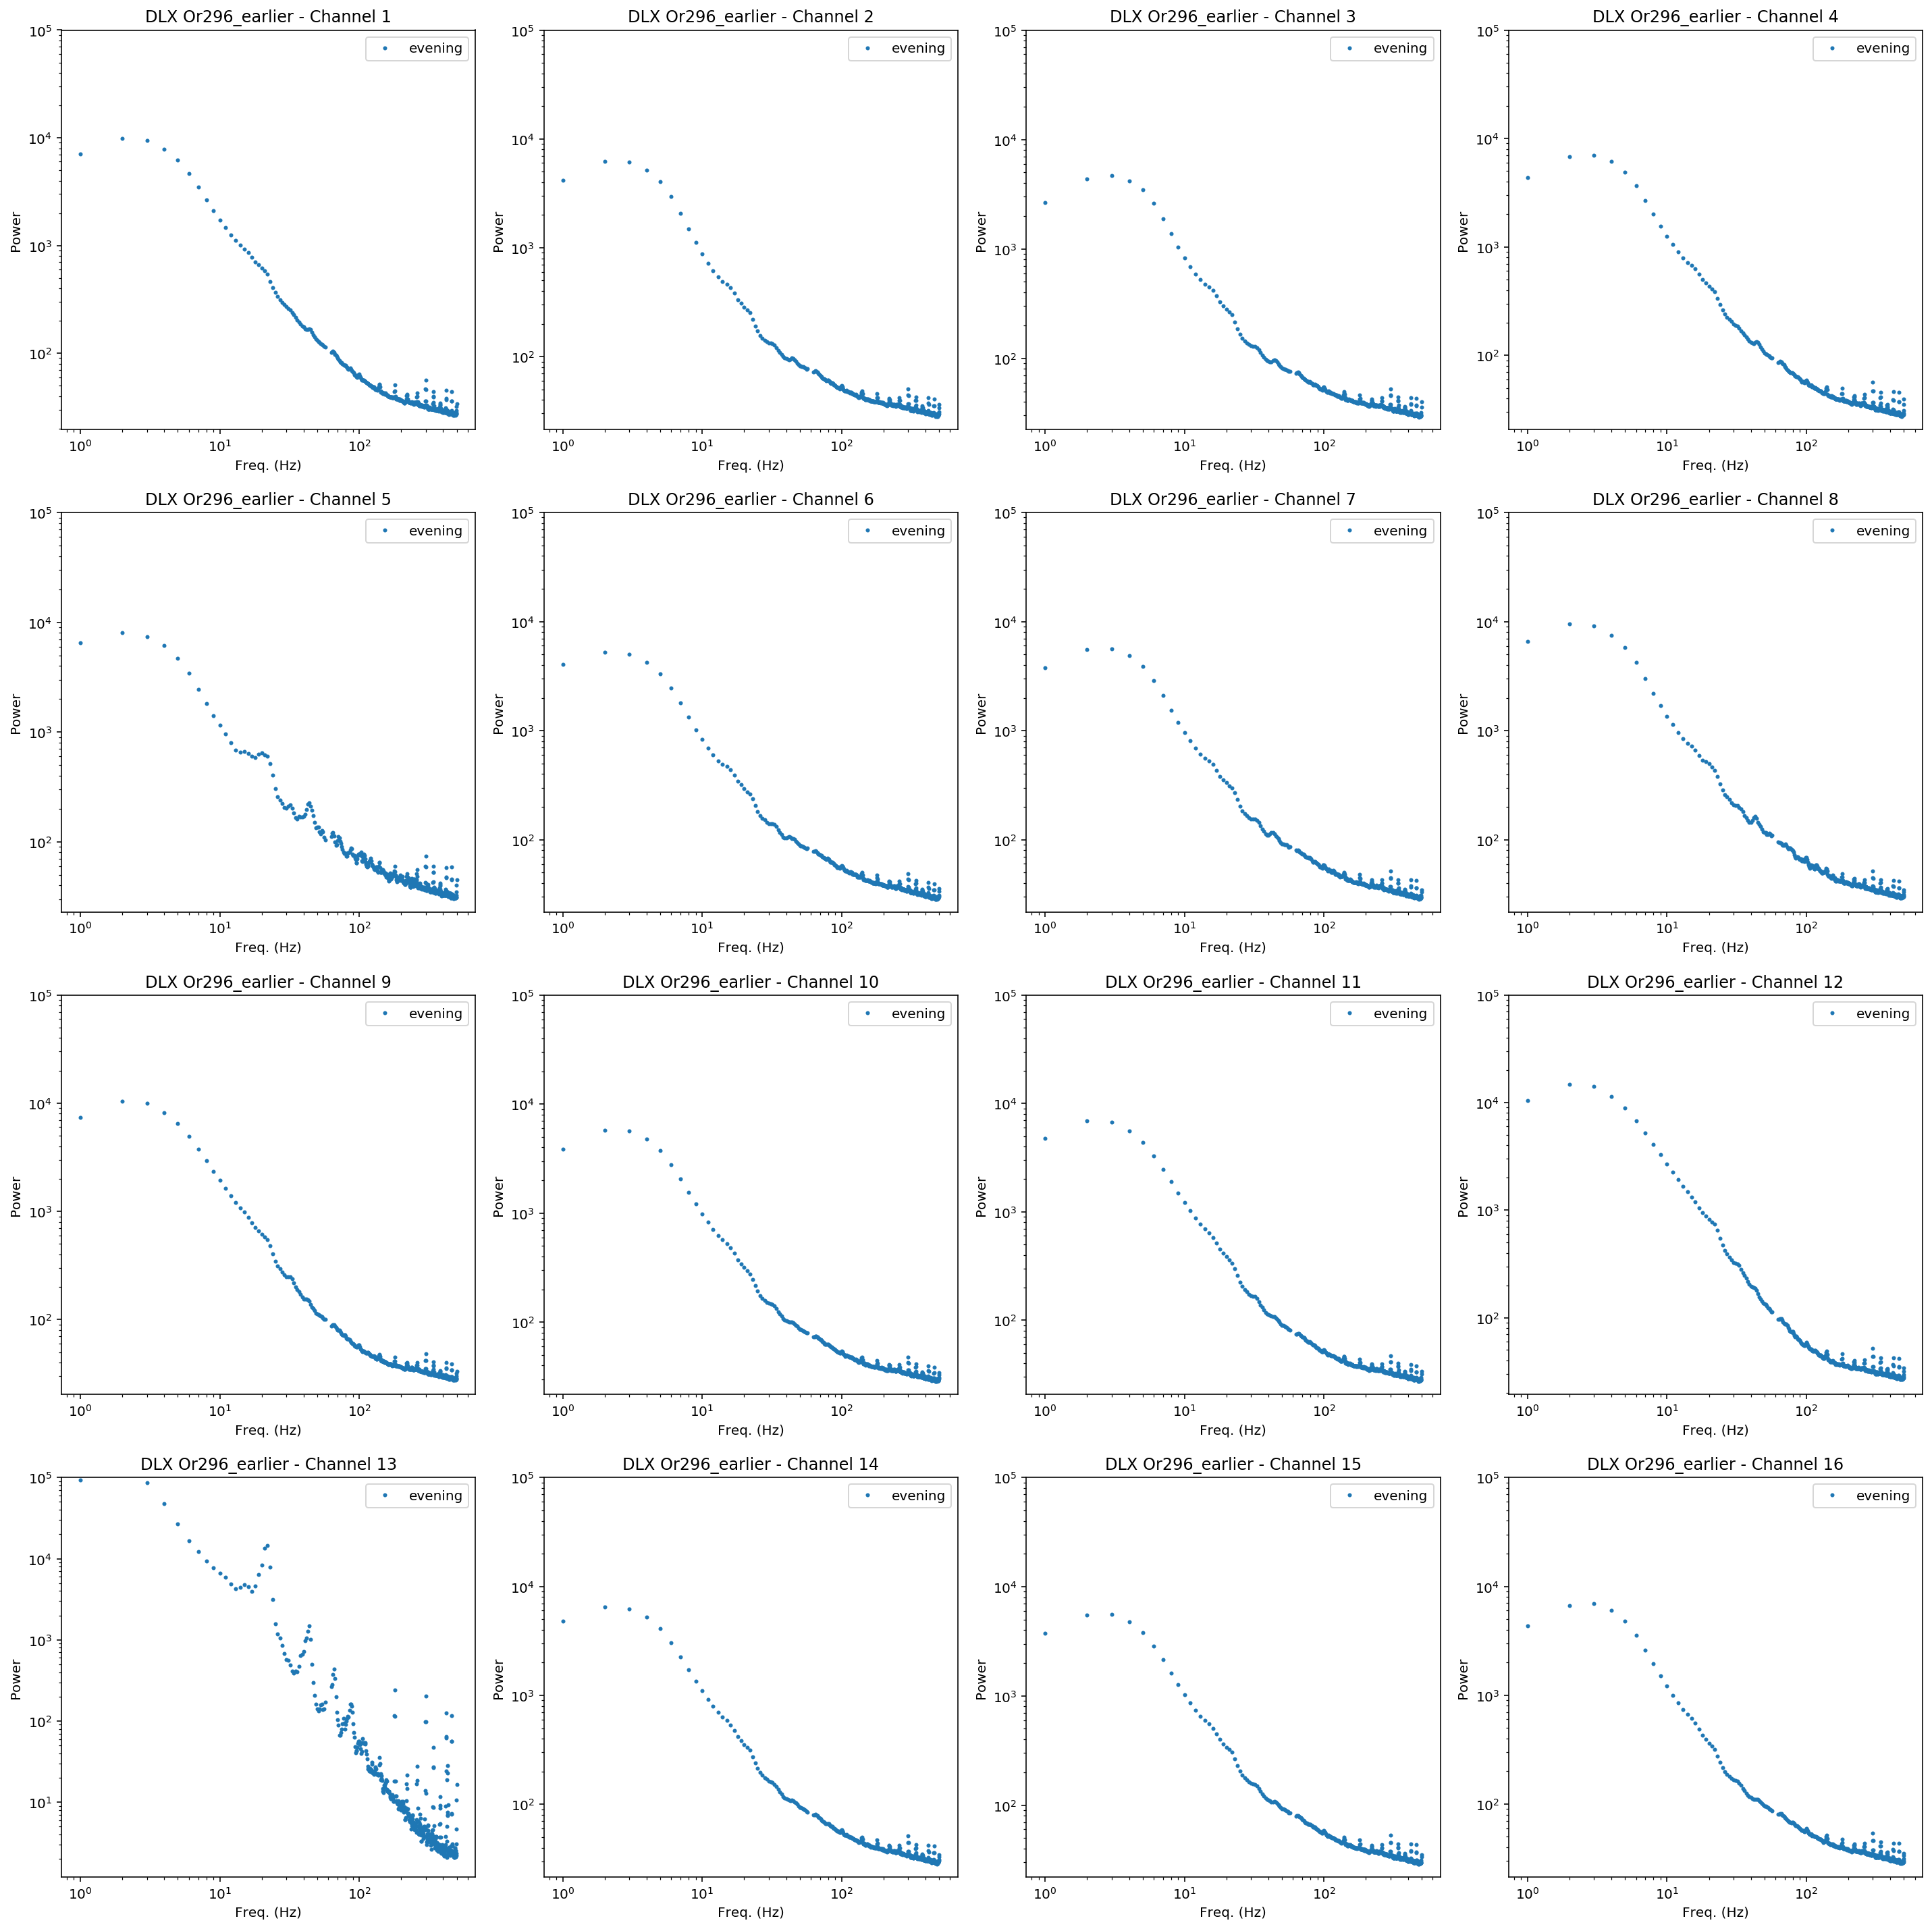

In [170]:
plot_channels(df_bird1_test, bird1)

#### !!! Manually define channels with broken electrodes to be removed from bird 1 data OR define single channel to keep

Note: Based on location of electrode array after brain dissection, we decide to keep channels 2, 4, 6, and 8 for Or296

In [171]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b1 = [13,  9, 10, 12, 14, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel = 6

In [172]:
if channels_used == "single":
    bad_channels_b1 = df_bird1['channel'].unique()[df_bird1['channel'].unique() != single_channel]

In [173]:
for bad_channel in np.concatenate((bad_channels_b1, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
    # Exclude bad channels and channels located outside HVC from original df
    df_bird1 = df_bird1[df_bird1.channel != bad_channel]

In [174]:
# Show new channel list
df_bird1['channel'].unique()

array([2, 4, 6, 8])

## Same for bird 2:

<ipython-input-169-96a3f2b9f84a>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


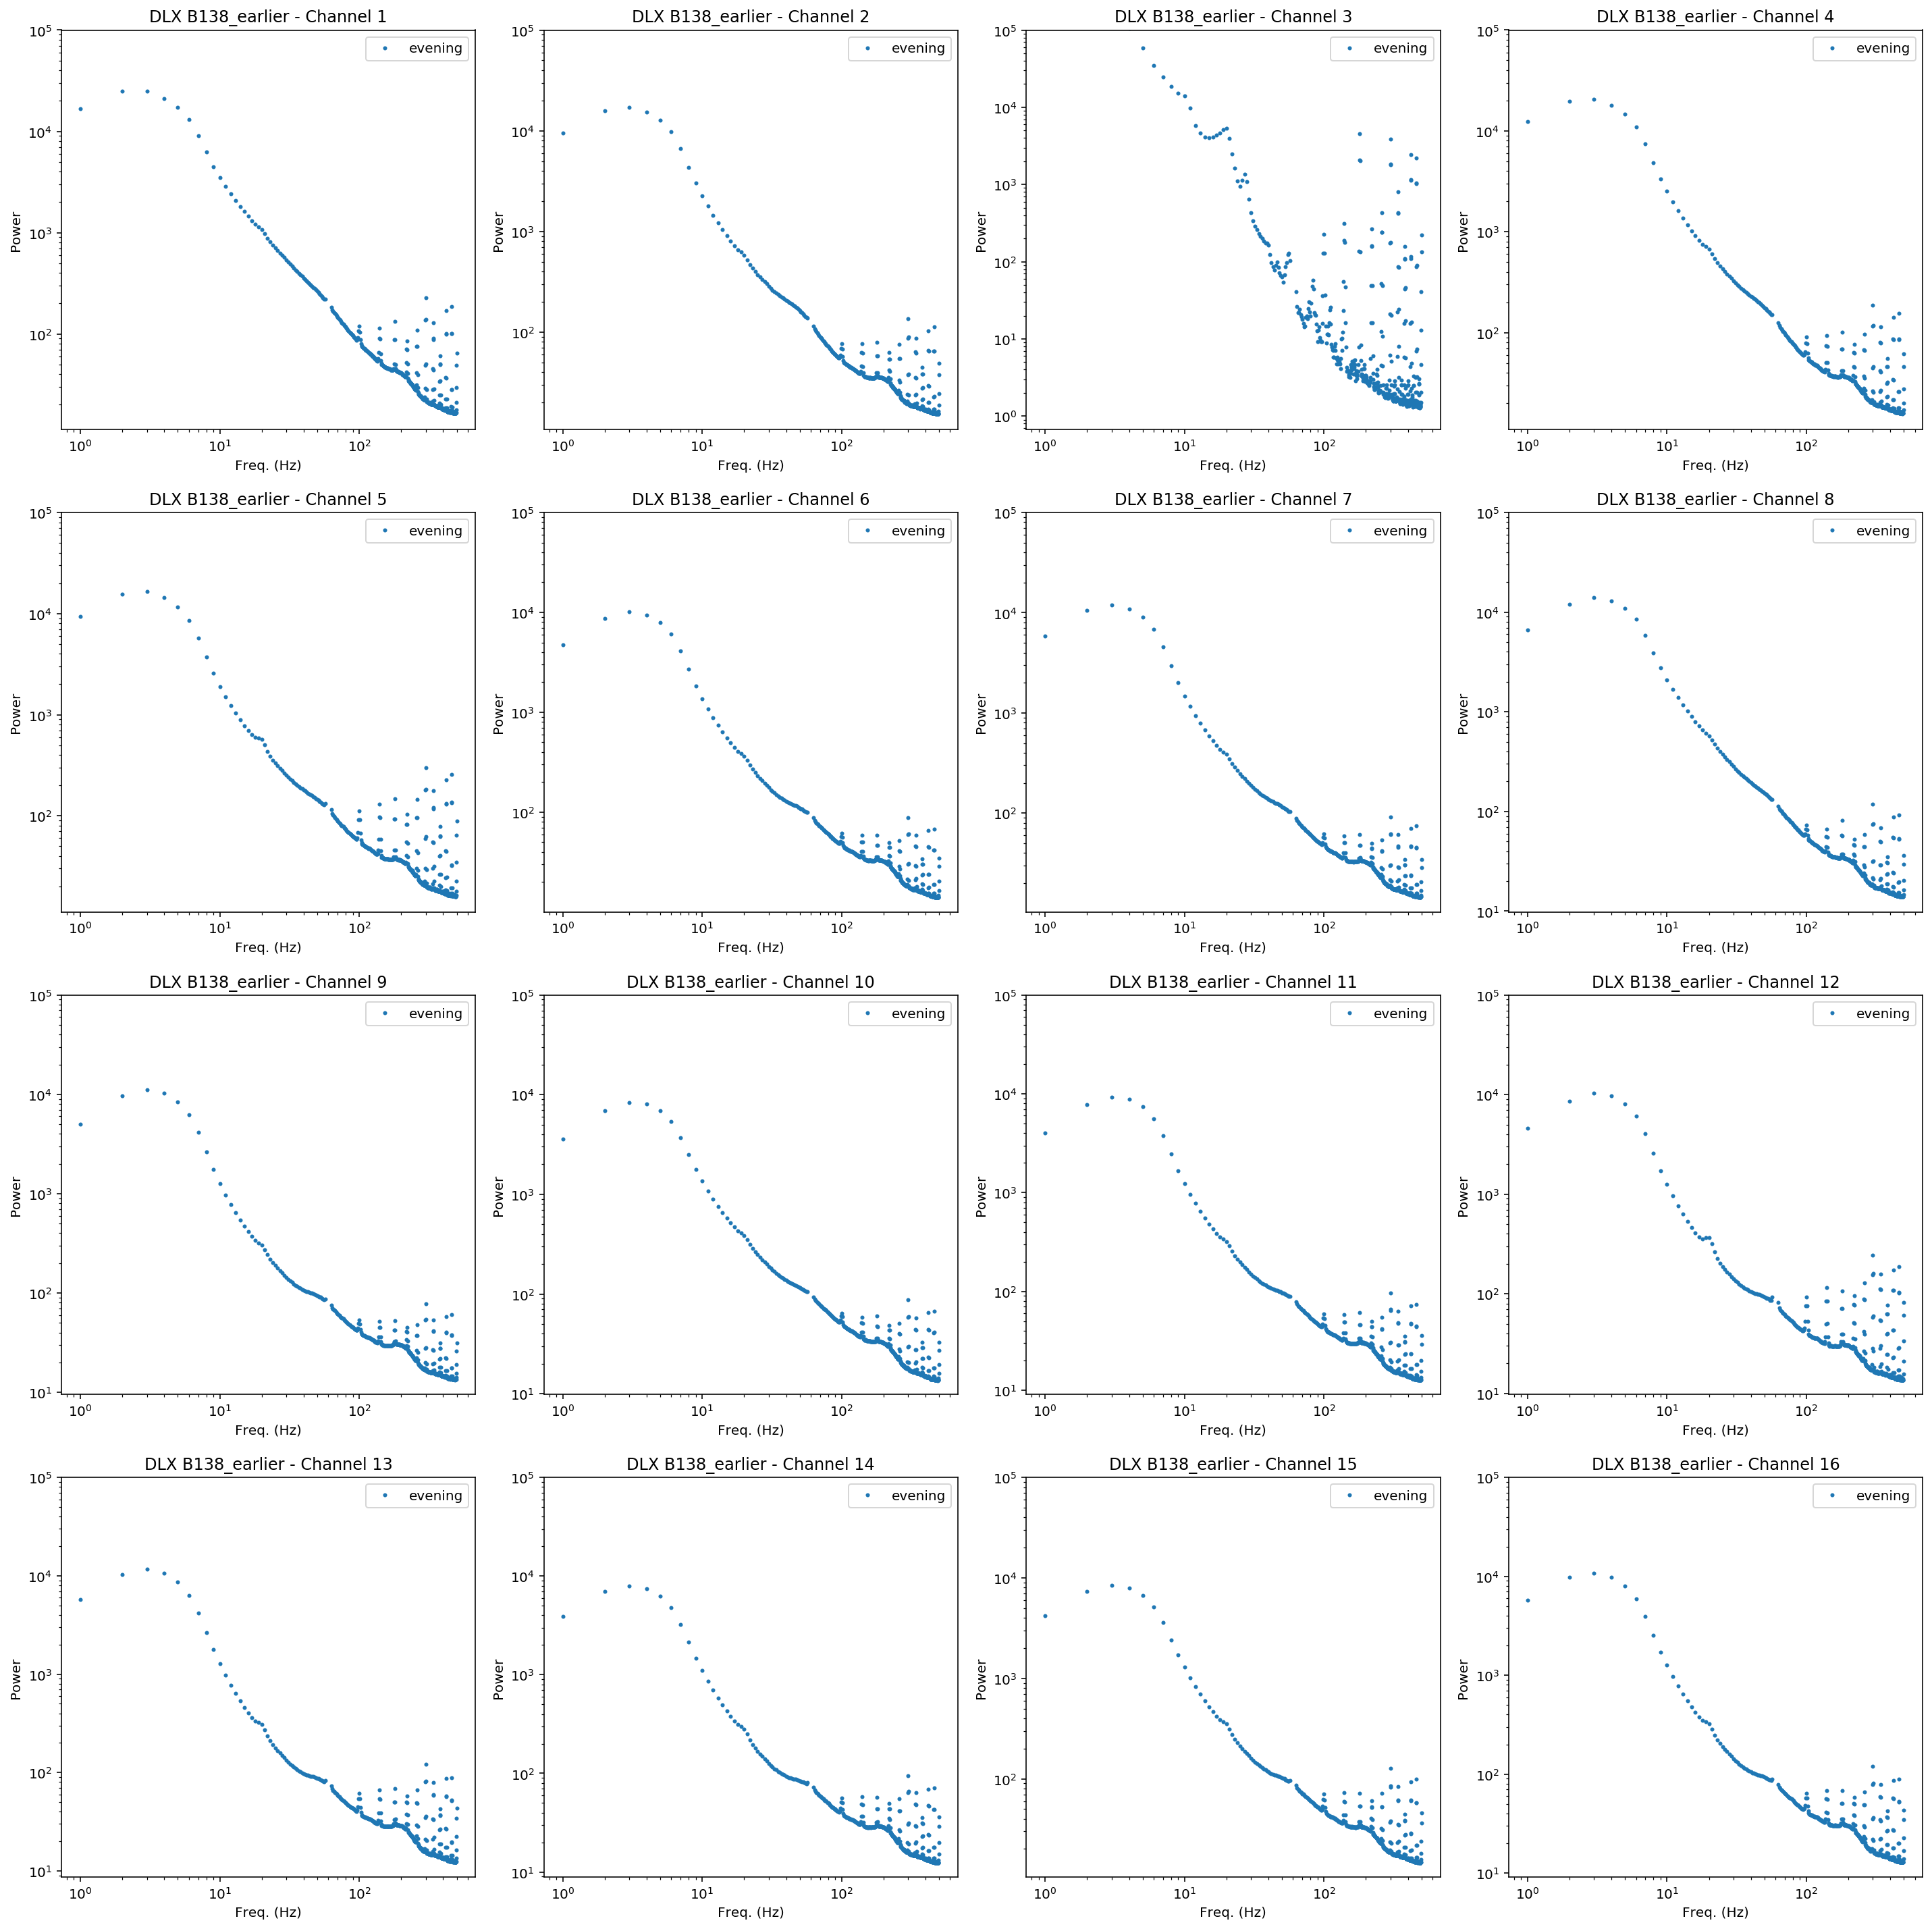

In [175]:
plot_channels(df_bird2_test, bird2)

#### !!! Manually define channels with broken electrodes to be removed from bird 2 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decide to keep channels 10, 11, 14 and 15 for B138.

In [176]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b2 = [3,  2,  4,  6,  8, 9,  12, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel2 = 10

In [177]:
if channels_used == "single":
    bad_channels_b2 = df_bird2['channel'].unique()[df_bird2['channel'].unique() != single_channel2]

In [178]:
for bad_channel in np.concatenate((bad_channels_b2, outside_HVC)):
    # Keep channels 11 and 15, even though they are labeled as outside HVC
    if bad_channel == 11 or bad_channel == 15:
        continue
        
    else: 
        # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
        df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]

        # Excluse bad channels and channels located outside HVC from original df
        df_bird2 = df_bird2[df_bird2.channel != bad_channel]

In [179]:
# Show new channel list
df_bird2["channel"].unique()

array([10, 11, 14, 15])

___

# Compare Power/Freq graph between animals by averaging across all channels

Average power values across all channels (excluding bad channels):

In [180]:
# Bird 1
df_bird1_test_2 = df_bird1_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird1_test_2 = df_bird1_test_2.reset_index()

# Bird 2
df_bird2_test_2 = df_bird2_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird2_test_2 = df_bird2_test_2.reset_index()

<ipython-input-181-4fe21c8764b3>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


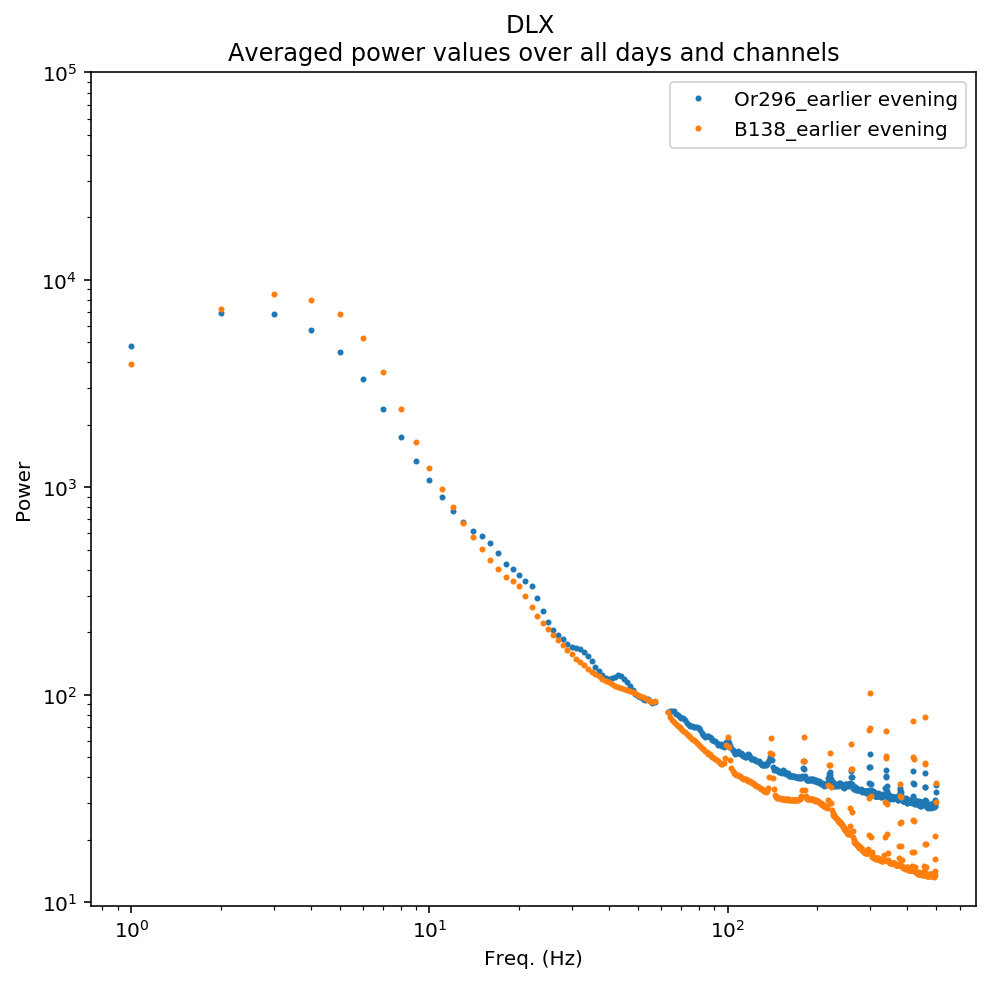

In [181]:
fig, ax = plt.subplots(figsize=(7, 7))

for name, group in df_bird1_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird1} {name}", marker='o', markersize=2, linestyle='', linewidth=2)
    
for name, group in df_bird2_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird2} {name}", marker='o', markersize=2, linestyle='', linewidth=2)

ax.set(**{
    "xlabel": "Freq. (Hz)",
    "ylabel": "Power",
    "title": "{} \nAveraged power values over all days and channels".format(condition)
})

# Change axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=100000)

# Add legend
ax.legend()
    
plt.tight_layout()    
fig.show()

___

# Take mean over all channels (per bird, per day, per hour, per freq) 
Excluding channels as defined above.

In [182]:
%%time
# Take mean over all channels
df_bird1 = df_bird1.groupby(["day", "daytime", "hour", "freq"])[["power"]].apply(np.mean)
df_bird2 = df_bird2.groupby(["day", "daytime", "hour", "freq"])[["power"]].apply(np.mean)

CPU times: user 2.42 s, sys: 38.1 ms, total: 2.46 s
Wall time: 2.45 s


In [183]:
# Sort by day, hour and freq
df_bird1 = df_bird1.reset_index().sort_values(["day", "hour", "freq"])
df_bird2 = df_bird2.reset_index().sort_values(["day", "hour", "freq"])

In [184]:
df_bird1

,day,daytime,hour,freq,power
0,44,evening,6,1,3972.059776
1,44,evening,6,2,6037.169964
2,44,evening,6,3,6250.352558
3,44,evening,6,4,5643.240153
4,44,evening,6,5,4700.996694
...,...,...,...,...,...
5935,47,evening,8,496,66.277921
5936,47,evening,8,497,64.215805
5937,47,evening,8,498,60.636804
5938,47,evening,8,499,61.292584


___

# Take mean over all hours (per bird, per day, per daytime, per freq) 
(Excluding bad channels defined above.)

In [185]:
%%time
# Take mean over all hours
df_bird1 = df_bird1.groupby(["day", "daytime", "freq"])[["power"]].apply(np.mean).reset_index()
df_bird2 = df_bird2.groupby(["day", "daytime", "freq"])[["power"]].apply(np.mean).reset_index()

CPU times: user 760 ms, sys: 9.57 ms, total: 770 ms
Wall time: 765 ms


___

# Sum power values in log freq ranges and divide by total sum

Define function to calculate power values and fractions and store them in a data frame:

In [186]:
def power_frac(df, freq_range, animal_ID):
    """
    Calculates the sum of power values within a defined frequency range
    and computes the fraction by dividing by the total power sum over all frequencies.
    The calculations are done per day, per daytime ("df" provides the average across all 
    hours for that daytime).
    The results are stored in a data frame.
    """
    df = df.groupby(["day", "daytime"])
    days = []
    daytimes = []
    pow_values_range = []
    pow_values_sum = []
    freq_ranges = []
    
    for name, group in df:
        pow_values = group["power"].values
        
        # np.add.reduceat takes the running sum over the specified slices
        pow_values_range.append(np.add.reduceat(pow_values, freq_range))
        
        # Calculate sum of power values across all frequencies for this day and daytime
        pow_values_sum.append([np.sum(pow_values),] * len(freq_range))
        
        # Also collect day, daytime and freq. range information
        days.append([name[0],] * len(freq_range))
        daytimes.append([name[1],] * len(freq_range))
        freq_ranges.append(freq_range_label)
        
    # Concatenate arrays to put into data frame
    days = np.concatenate(days)
    daytimes = np.concatenate(daytimes)
    freq_ranges = np.concatenate(freq_ranges)
    pow_values_range = np.concatenate(pow_values_range)
    pow_values_sum = np.concatenate(pow_values_sum)
    
    # Generate data frame
    df_fcs = pd.DataFrame()
    df_fcs["day"] = days
    df_fcs["daytime"] = daytimes
    df_fcs["freq_range"] = freq_ranges
    df_fcs["power_values_range"] = pow_values_range
    df_fcs["power_values_sum"] = pow_values_sum
    
    # Calculate fold change
    df_fcs["power_fraction"] = df_fcs["power_values_range"] / df_fcs["power_values_sum"]
    
    # Add animal ID and condition
    df_fcs["animal_ID"] = animal_ID
    df_fcs["condition"] = condition
    
    return df_fcs

Calculate power values and fractions for both birds:

In [187]:
# Bird 1
df_bird1_fcs = power_frac(df_bird1, freq_range, animal_ID=bird1)

# Bird 2
df_bird2_fcs = power_frac(df_bird2, freq_range, animal_ID=bird2)

In [188]:
df_bird1_fcs

,day,daytime,freq_range,power_values_range,power_values_sum,power_fraction,animal_ID,condition
0,44,evening,1-10,40015.773978,64484.298639,0.620551,Or296_earlier,DLX
1,44,evening,11-100,11709.584356,64484.298639,0.181588,Or296_earlier,DLX
2,44,evening,101-500,12758.940305,64484.298639,0.197861,Or296_earlier,DLX
3,45,evening,1-10,42820.510328,67652.168200,0.632951,Or296_earlier,DLX
4,45,evening,11-100,12743.726696,67652.168200,0.188371,Or296_earlier,DLX
5,45,evening,101-500,12087.931177,67652.168200,0.178678,Or296_earlier,DLX
6,46,evening,1-10,40863.242199,72211.768586,0.565881,Or296_earlier,DLX
7,46,evening,11-100,15810.683477,72211.768586,0.218949,Or296_earlier,DLX
8,46,evening,101-500,15537.842910,72211.768586,0.215171,Or296_earlier,DLX
9,47,evening,1-10,34828.161365,64262.660289,0.541966,Or296_earlier,DLX


___

# Fill in missing days with N/A and concatenate datasets from different animals

Supplement NaNs values to all days that do not have a recording for each bird. After this, each dataframe includes all days (0-143). (143 is last day recorded for any bird.)

In [189]:
# Show days before supplementing NaNs
np.sort(df_bird1["day"].unique())

array([44, 45, 46, 47])

In [190]:
def add_NA(df_bird):
    """
    Add NA values to data frame for all days between 0 and 90 that are missing.
    This function works for the data frames that still include power values for all frequencies.
    """
    freq_range_clean = df_bird["freq"].unique()

    for daytime in df_bird["daytime"].unique():
        # Get one daytime
        df = df_bird[df_bird["daytime"] == daytime]
        df_temp = pd.DataFrame()
        
        # Find all days that are missing from data frame 
        days_missing = np.array(list(set(df["day"].unique()) ^ set(np.arange(144))))

        if len(days_missing) > 0:
            # Add them to new dataframe, repeating each day as many times as there are frequencies
            df_temp["day"] = np.repeat(days_missing, len(freq_range_clean))
            # Add frequency values for each unique day
            df_temp["freq"] = np.concatenate([freq_range_clean,] * len(days_missing))
            # Add daytime
            df_temp["daytime"] = daytime
            # Add NA to power values
            df_temp["power"] = np.nan

            df_bird = pd.concat([df_bird, df_temp])
        
    return df_bird

In [191]:
df_bird1 = add_NA(df_bird1)
df_bird2 = add_NA(df_bird2)

In [192]:
# Show days after supplementing NaNs
np.sort(df_bird1["day"].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143])

Same for data frames containing sum of freq ranges:

In [193]:
def add_NA_sum(df_bird):
    """
    Add NA values to data frame for all days between 0 and 90 that are missing.
    This function works for the data frames contain sums over freq ranges and fractions.
    """
    freq_ranges = df_bird["freq_range"].unique()

    for daytime in df_bird["daytime"].unique():
        # Get one daytime
        df = df_bird[df_bird["daytime"] == daytime]
        df_temp = pd.DataFrame()
        
        # Find all days that are missing from data frame 
        days_missing = np.array(list(set(df["day"].unique()) ^ set(np.arange(144))))

        if len(days_missing) > 0:
            # Add them to new dataframe, repeating each day as many times as there are frequencies
            df_temp["day"] = np.repeat(days_missing, len(freq_ranges))
            # Add frequency ranges for each unique day
            df_temp["freq_range"] = np.concatenate([freq_ranges,] * len(days_missing))
            # Add daytime
            df_temp["daytime"] = daytime
            # Add NA to power values
            df_temp["power_values_range"] = np.nan
            df_temp["power_values_sum"] = np.nan
            df_temp["power_fraction"] = np.nan
            
            # Add animal ID and condition
            df_temp["animal_ID"] = df_bird["animal_ID"].unique()[0]
            df_temp["condition"] = df_bird["condition"].unique()[0]

            df_bird = pd.concat([df_bird, df_temp])

    return df_bird

In [194]:
df_bird1_fcs = add_NA_sum(df_bird1_fcs)
df_bird2_fcs = add_NA_sum(df_bird2_fcs)

In [195]:
# Show days after supplementing NaNs
np.sort(df_bird1_fcs["day"].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143])

Sort, concatenate and save data frames as csv:

In [196]:
# Sort data frames by day, daytime and freq
df_bird1 = df_bird1.sort_values(["day", "daytime", "freq"])
df_bird2 = df_bird2.sort_values(["day", "daytime", "freq"])
df_bird1_fcs = df_bird1_fcs.sort_values(["day", "daytime", "freq_range"])
df_bird2_fcs = df_bird2_fcs.sort_values(["day", "daytime", "freq_range"])

# Add condition and animal ID to data frames containing sums over freq ranges and fractions
df_bird1["condition"] = condition
df_bird1["animal_ID"] = bird1
df_bird2["condition"] = condition
df_bird2["animal_ID"] = bird2

# Concatenate data frames from replicates
df_concat = pd.concat([df_bird1, df_bird2]) # Contains all power values averaged across channels and hours
df_concat_fcs = pd.concat([df_bird1_fcs, df_bird2_fcs]) # Contains sums over freq ranges and fractions

# if channels_used == "multi":
#     # Save as csv
#     df_concat.to_csv(f"{condition}_HOUR-TEST_all_channel_multi-channel.csv", index=False)
#     df_concat_fcs.to_csv(f"{condition}_HOUR-TEST_freq-ranges_multi-channel.csv", index=False)
    
# if channels_used == "single":
#     # Save as csv
#     df_concat.to_csv(f"{condition}_all_channel-hour-test_single-channel.csv", index=False)
#     df_concat_fcs.to_csv(f"{condition}_freq-ranges_hour-test_single-channel.csv", index=False)

___

# Compare to power values in later hours

In [197]:
df_concat

,day,daytime,freq,power,condition,animal_ID
0,0,evening,1,NaN,DLX,Or296_earlier
1,0,evening,2,NaN,DLX,Or296_earlier
2,0,evening,3,NaN,DLX,Or296_earlier
3,0,evening,4,NaN,DLX,Or296_earlier
4,0,evening,5,NaN,DLX,Or296_earlier
...,...,...,...,...,...,...
69295,143,evening,496,NaN,DLX,B138_earlier
69296,143,evening,497,NaN,DLX,B138_earlier
69297,143,evening,498,NaN,DLX,B138_earlier
69298,143,evening,499,NaN,DLX,B138_earlier


Load in regular data to compare to:

In [198]:
dlx_df = pd.read_csv("DLX_all_channel-hour-average_multi-channel.csv")
dlx_df_evening = dlx_df[dlx_df["daytime"] == "evening"]
dlx_df_evening

,day,daytime,freq,power,condition,animal_ID
0,0,evening,1,NaN,DLX,Or296
1,0,evening,2,NaN,DLX,Or296
2,0,evening,3,NaN,DLX,Or296
3,0,evening,4,NaN,DLX,Or296
4,0,evening,5,NaN,DLX,Or296
...,...,...,...,...,...,...
284620,143,evening,496,NaN,DLX,B138
284621,143,evening,497,NaN,DLX,B138
284622,143,evening,498,NaN,DLX,B138
284623,143,evening,499,NaN,DLX,B138


In [199]:
df_all_evening = pd.concat([dlx_df_evening, df_concat])

Plot data for freq. ranges defined at the top of the notebook:

In [200]:
def plot_brain_waves(df):
    fig, axs = plt.subplots(figsize=(20,20), nrows=5)
    freq_range_label = ["1-3", "4-7", "8-12", "18-25", "30-70"]

    # Customize figure 
    colors = ["red", "orange", "blue", "cornflowerblue"]
    marker_size = 40
    fontsize = 16
    fontdict = {
        'weight': 'normal',
        'size': fontsize,
        }

    condition_animal_IDs = []

    for condition in df["condition"].unique():
        for i, animal_ID in enumerate(df["animal_ID"].unique()):
            # Get data from one animal
            temp = df[(df["condition"] == condition) & (df["animal_ID"] == animal_ID)]

            for name, group in temp.groupby(["day", "daytime"]):
                pow_values = group["power"].values

                # # Use np.add.reduceat to get sum of power values in freq range
                # # then divide by the freq range lengths to get mean
                # means = np.add.reduceat(pow_values, freq_range) / [10, 95, 400]
                
                # Calculate means
                mean1 = np.mean(pow_values[0:3]) # delta
                mean2 = np.mean(pow_values[3:7]) # theta
                mean3 = np.mean(pow_values[7:12]) # alpha
                mean4 = np.mean(pow_values[17:25]) # beta
                mean5 = np.mean(pow_values[29:70]) # gamma
                
                # Calculate standard deviation
                c1 = np.std(pow_values[0:3]) # delta
                c2 = np.std(pow_values[3:7]) # theta
                c3 = np.std(pow_values[7:12]) # alpha
                c4 = np.std(pow_values[17:25]) # beta
                c5 = np.std(pow_values[29:70]) # gamma

                day = name[0]               

                if condition + str(animal_ID) not in condition_animal_IDs:
                    axs[0].scatter(day, mean1, s=marker_size, c=colors[i], label=f"{condition} {animal_ID}")  
                    axs[1].scatter(day, mean2, s=marker_size, c=colors[i], label=f"{condition} {animal_ID}")
                    axs[2].scatter(day, mean3, s=marker_size, c=colors[i], label=f"{condition} {animal_ID}") 
                    axs[3].scatter(day, mean4, s=marker_size, c=colors[i], label=f"{condition} {animal_ID}") 
                    axs[4].scatter(day, mean5, s=marker_size, c=colors[i], label=f"{condition} {animal_ID}") 
                    condition_animal_IDs.append(condition + str(animal_ID))
                else:
                    axs[0].scatter(day, mean1, s=marker_size, c=colors[i])
                    axs[1].scatter(day, mean2, s=marker_size, c=colors[i])
                    axs[2].scatter(day, mean3, s=marker_size, c=colors[i]) 
                    axs[3].scatter(day, mean4, s=marker_size, c=colors[i]) 
                    axs[4].scatter(day, mean5, s=marker_size, c=colors[i])
                # Add error bar
                axs[0].errorbar(day, mean1, yerr=c1, fmt="", ecolor="black", zorder=-1)
                axs[1].errorbar(day, mean2, yerr=c2, fmt="", ecolor="black", zorder=-1)
                axs[2].errorbar(day, mean3, yerr=c3, fmt="", ecolor="black", zorder=-1)
                axs[3].errorbar(day, mean4, yerr=c4, fmt="", ecolor="black", zorder=-1)
                axs[4].errorbar(day, mean5, yerr=c5, fmt="", ecolor="black", zorder=-1)

    daytime = df["daytime"].unique()[0]
    axs[0].set_title(f"{daytime} - Average power in frequency range {freq_range_label[0]} Hz (delta)", fontsize=fontsize+2)
    axs[1].set_title(f"{daytime} - Average power in frequency range {freq_range_label[1]} Hz (theta)", fontsize=fontsize+2)
    axs[2].set_title(f"{daytime} - Average power in frequency range {freq_range_label[2]} Hz (alpha)", fontsize=fontsize+2)
    axs[3].set_title(f"{daytime} - Average power in frequency range {freq_range_label[3]} Hz (beta)", fontsize=fontsize+2)
    axs[4].set_title(f"{daytime} - Average power in frequency range {freq_range_label[4]} Hz (gamma)", fontsize=fontsize+2)

    axs[0].legend(bbox_to_anchor=(1.001, 1.025), loc='upper left', fontsize=fontsize)
    
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        ax.set_xlabel("Days post-injection", fontdict=fontdict)
        ax.set_ylabel("Average power", fontdict=fontdict)

        # Change y axis to log scale
        # ax.set_yscale('log')
        # ax.set_ylim(top=300000)
        
        # Set x-axis limit
        ax.set_xlim(left=42.5, right=47.5)

        ax.margins(x=0.01)
        # ax.grid(False)

        # Set major ticks to be multiples of 2
        ax.xaxis.set_major_locator(MultipleLocator(2))
        # For the minor ticks, use no labels; default NullFormatter.
        ax.xaxis.set_minor_locator(MultipleLocator(1))    

    plt.tight_layout()

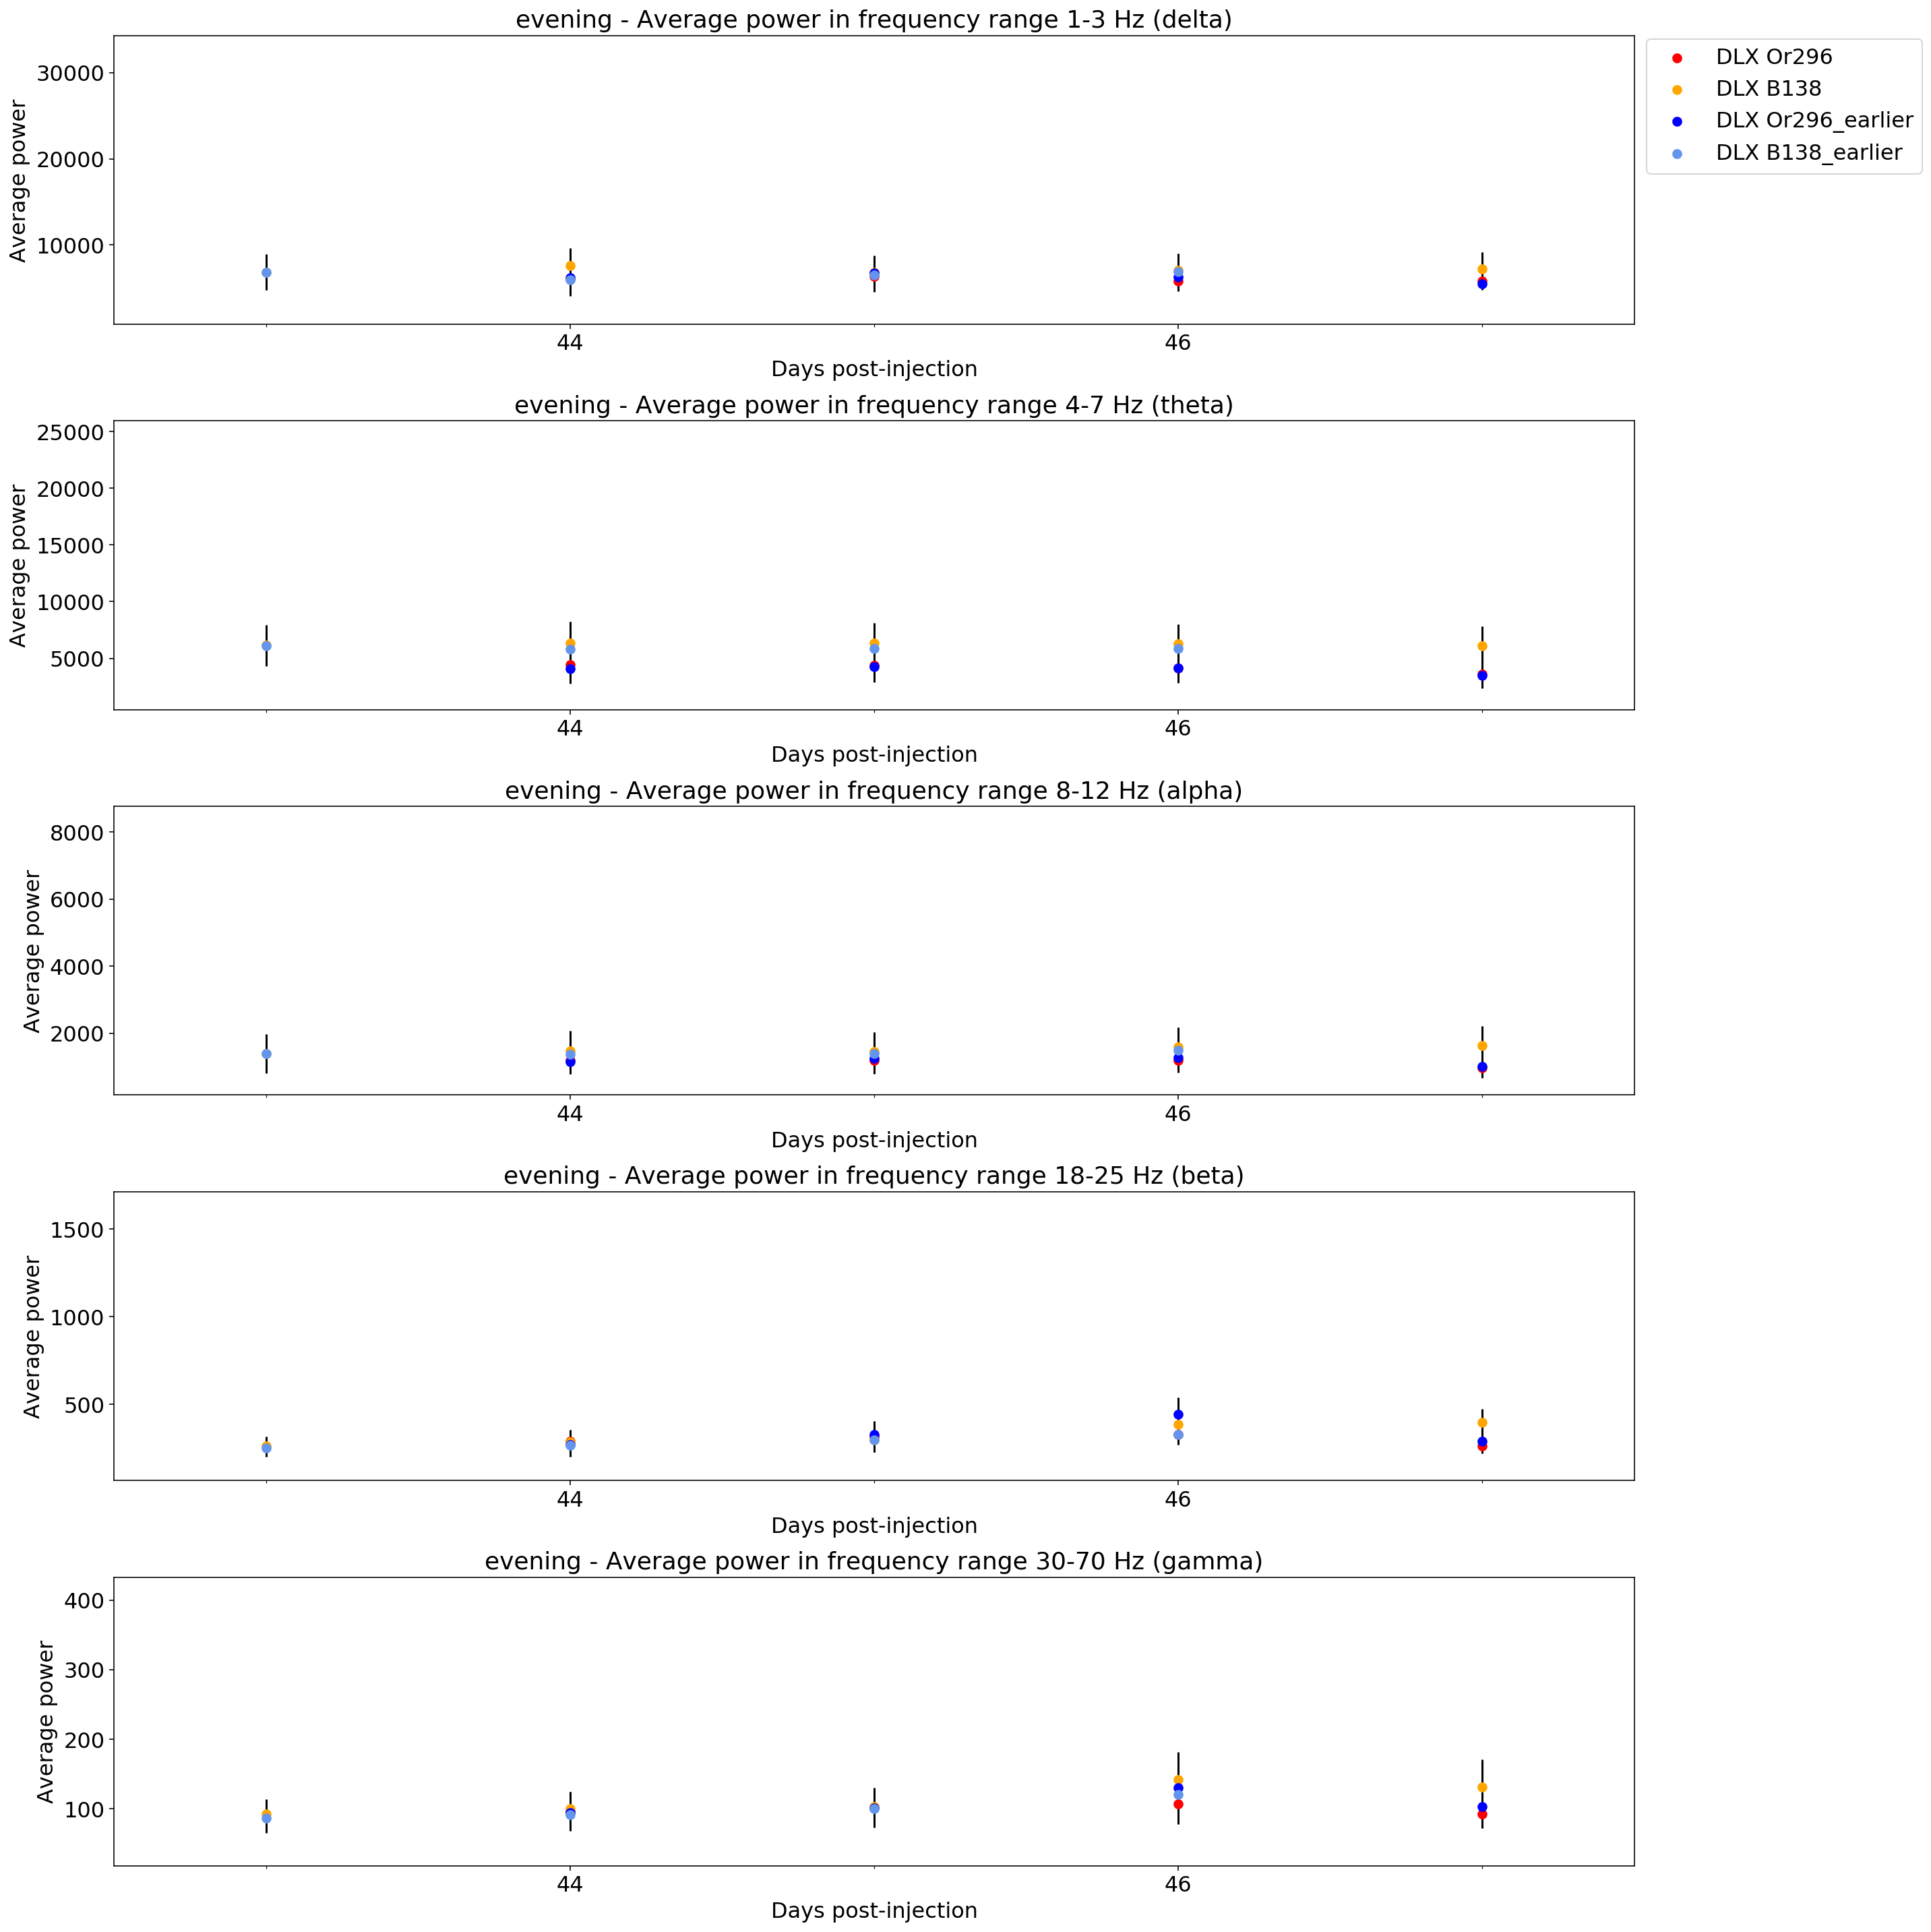

In [201]:
plot_brain_waves(df_all_evening)